In [1]:
import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix

from warnings import filterwarnings
filterwarnings('ignore')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2021-12-10 02:00:38.072846: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-10 02:00:38.073015: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<img src="https://i.ibb.co/PWvpT9F/header.png" alt="header" border="0" width=800 height=300>

# Introduction

<div style="font-size:110%;line-height:155%">
<p>Hi,</p>
<p>while I'm still enjoying my deep-learning adventure, reading and learning a ton of stuff - I decided it's time to implement different kinds of networks with this month competition. With this notebook I'm trying a <b>Deep & Cross</b> architecture. The idea here is to create polynomial features of increasing degrees with each layer while training a fully-connected neural net in parallel. Both networks will be concatenated in the end to make the final prediction.
    
<blockquote><img src="https://i.ibb.co/37CQmF9/DNN-CROSS-DEEP.png" width="35%" alt="DNN-CROSS-DEEP" border="0"></blockquote>
    
<p>Feel free to take a look at my other notebooks, covering some different ideas and architectures:
    <li><a href="https://www.kaggle.com/mlanhenke/tps-12-simple-nn-baseline-keras">Simple NN Baseline</a></li>
    <li><a href="https://www.kaggle.com/mlanhenke/tps-12-deep-wide-nn-keras">Deep & Wide NN </a></li>
    <li><a href="https://www.kaggle.com/mlanhenke/tps-12-bn-autoencoder-nn-keras">Bottleneck Autoencoder</a></li>
    <li><a href="https://www.kaggle.com/mlanhenke/tps-12-denoising-autoencoder-nn-keras">Deepstack Denoising Autoencoder</a></li>
</p>
    
<em>Thank you very much for taking some time to read my notebook. Please leave an upvote if you find any of this information useful.</em>
</div>

# Import & Prepare Data

In [2]:
%%time
# import train & test data
df_train = pd.read_csv('../input/tabular-playground-series-dec-2021/train.csv')
df_test = pd.read_csv('../input/tabular-playground-series-dec-2021/test.csv')

sample_submission = pd.read_csv('../input/tabular-playground-series-dec-2021/sample_submission.csv')

# drop underrepresented class
df_train = df_train[df_train['Cover_Type'] != 5]

# apply feature-engineering
# thanks to https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion/293373
df_train['Aspect'][df_train['Aspect'] < 0] += 360 
df_train['Aspect'][df_train['Aspect'] > 359] -= 360
df_test['Aspect'][df_test['Aspect'] < 0] += 360 
df_test['Aspect'][df_test['Aspect'] > 359] -= 360

df_train.loc[df_train["Hillshade_9am"] < 0, "Hillshade_9am"] = 0
df_test.loc[df_test["Hillshade_9am"] < 0, "Hillshade_9am"] = 0

df_train.loc[df_train["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0
df_test.loc[df_test["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0

df_train.loc[df_train["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0
df_test.loc[df_test["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0

df_train.loc[df_train["Hillshade_9am"] > 255, "Hillshade_9am"] = 255
df_test.loc[df_test["Hillshade_9am"] > 255, "Hillshade_9am"] = 255

df_train.loc[df_train["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255
df_test.loc[df_test["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255

df_train.loc[df_train["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255
df_test.loc[df_test["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255

# split dataframes for later modeling
X = df_train.drop(columns=['Id','Cover_Type','Soil_Type7','Soil_Type15','Soil_Type1']).copy()
y = df_train['Cover_Type'].copy()

X_test = df_test.drop(columns=['Id','Soil_Type7','Soil_Type15','Soil_Type1']).copy()

# create label-encoded one-hot-vector for softmax, mutliclass classification
le = LabelEncoder()
target = keras.utils.to_categorical(le.fit_transform(y))

print(X.shape, y.shape, target.shape, X_test.shape)

(3999999, 51) (3999999,) (3999999, 6) (1000000, 51)
CPU times: user 18 s, sys: 5.08 s, total: 23.1 s
Wall time: 33.2 s


# Model Setup

In [3]:
# define helper functions
def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    print(f"Seed set to: {seed}")

def plot_eval_results(scores, n_splits):
    cols = 5
    rows = int(np.ceil(n_splits/cols))
    
    fig, ax = plt.subplots(rows, cols, tight_layout=True, figsize=(20,2.5))
    ax = ax.flatten()

    for fold in range(len(scores)):
        df_eval = pd.DataFrame({'train_loss': scores[fold]['loss'], 'valid_loss': scores[fold]['val_loss']})

        sns.lineplot(
            x=df_eval.index,
            y=df_eval['train_loss'],
            label='train_loss',
            ax=ax[fold]
        )

        sns.lineplot(
            x=df_eval.index,
            y=df_eval['valid_loss'],
            label='valid_loss',
            ax=ax[fold]
        )

        ax[fold].set_ylabel('')

    sns.despine()

def plot_cm(cm):
    metrics = {
        'accuracy': cm / cm.sum(),
        'recall' : cm / cm.sum(axis=1),
        'precision': cm / cm.sum(axis=0)
    }
    
    fig, ax = plt.subplots(1,3, tight_layout=True, figsize=(15,5))
    ax = ax.flatten()

    mask = (np.eye(cm.shape[0]) == 0) * 1

    for idx, (name, matrix) in enumerate(metrics.items()):

        ax[idx].set_title(name)

        sns.heatmap(
            data=matrix,
            cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True),
            cbar=False,
            mask=mask,
            lw=0.25,
            annot=True,
            fmt='.2f',
            ax=ax[idx]
        )
    sns.despine()

In [4]:
# define callbacks
lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", 
    factor=0.5, 
    patience=5, 
    verbose=True
)

es = keras.callbacks.EarlyStopping(
    monitor="val_acc", 
    patience=10, 
    verbose=True, 
    mode="max", 
    restore_best_weights=True
)

In [5]:
# create custom dense-block
class DenseBlock(layers.Layer):
    def __init__(self, units, activation='relu', dropout_rate=0, l2=0):
        super().__init__()
        self.dense = layers.Dense(
            units, activation,
            kernel_initializer="lecun_normal", 
            kernel_regularizer=keras.regularizers.l2(l2)
        )
        self.batchn = layers.BatchNormalization()
        self.dropout = layers.Dropout(dropout_rate)
    
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.batchn(x)
        x = self.dropout(x)
        return x
    
# create dense & cross model
class CrossNet(keras.Model):
    def __init__(self, hidden_layers, activation='relu', dropout_rate=0, l2=0):
        super().__init__()
        self.dense_layers = [
            DenseBlock(units, activation, l2)
            for units in hidden_layers
        ]
        self.dense = layers.Dense(units=X.shape[-1])
        self.concat = layers.Concatenate()
        self.batchn = layers.BatchNormalization()
        self.softmax = layers.Dense(units=target.shape[-1], activation='softmax')
        
    def call(self, inputs):
        dense, cross = inputs, inputs
        for dense_layer in self.dense_layers:
            dense = dense_layer(dense)
            cross_current = self.dense(cross)
            cross = inputs * cross_current + cross
        cross = self.batchn(cross)
        merged = self.concat([dense, cross])
        return self.softmax(merged)

# Training

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    tf_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("Running on TPU:", tpu.master())
except:
    tf_strategy = tf.distribute.get_strategy()
    print(f"Running on {tf_strategy.num_replicas_in_sync} replicas")
    print("Number of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2021-12-10 02:01:17.813751: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-10 02:01:17.817408: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-10 02:01:17.817449: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-10 02:01:17.817477: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (7fc39d5f8279): /proc/driver/nvidia/version does not exist
2021-12-10 02:01:17.820223: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Running on TPU: grpc://10.0.0.2:8470


In [7]:
seed = 2021
set_seed(seed)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

predictions = []
oof_preds = {'y_valid': list(), 'y_hat': list()}
scores_nn = {fold:None for fold in range(cv.n_splits)}

for fold, (idx_train, idx_valid) in enumerate(cv.split(X,y)):
    X_train, y_train = X.iloc[idx_train], target[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], target[idx_valid]

    # scale data
    scl = StandardScaler()
    X_train = scl.fit_transform(X_train)
    X_valid = scl.transform(X_valid)
    
    with tf_strategy.scope():
        model = CrossNet(
            hidden_layers=[128 for _ in range(5)],
            activation='selu',
            dropout_rate=0.3
        )

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss=keras.losses.CategoricalCrossentropy(),
            metrics=['acc']
        )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=500,
        batch_size=4096,
        shuffle=True,
        verbose=False,
        callbacks=[lr,es]
    )

    scores_nn[fold] = history.history

    oof_preds['y_valid'].extend(y.iloc[idx_valid])
    oof_preds['y_hat'].extend(model.predict(X_valid, batch_size=4096))

    prediction = model.predict(scl.transform(X_test), batch_size=4096)
    predictions.append(prediction)

    del model, prediction
    gc.collect()
    K.clear_session()

    print('_'*65)
    print(f"Fold {fold+1} || Min Val Loss: {np.min(scores_nn[fold]['val_loss'])}")

overall_score = [np.min(scores_nn[fold]['val_loss']) for fold in range(cv.n_splits)]
print('_'*65)
print(f"Overall Mean Validation Loss: {np.mean(overall_score)}")

Seed set to: 2021

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00050: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00065: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
_________________________________________________________________
Fold 1 || Min Val Loss: 0.077738918364048

Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00053: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00059: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00064: ReduceLROnPlateau reducing learning rate to 1.562

# Evaluation & Submission

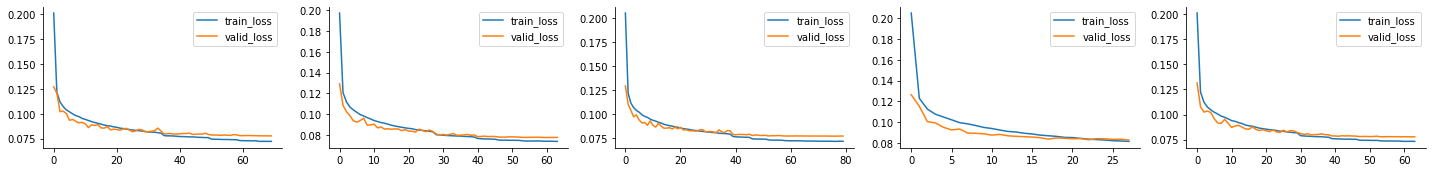

In [8]:
plot_eval_results(scores_nn, cv.n_splits)

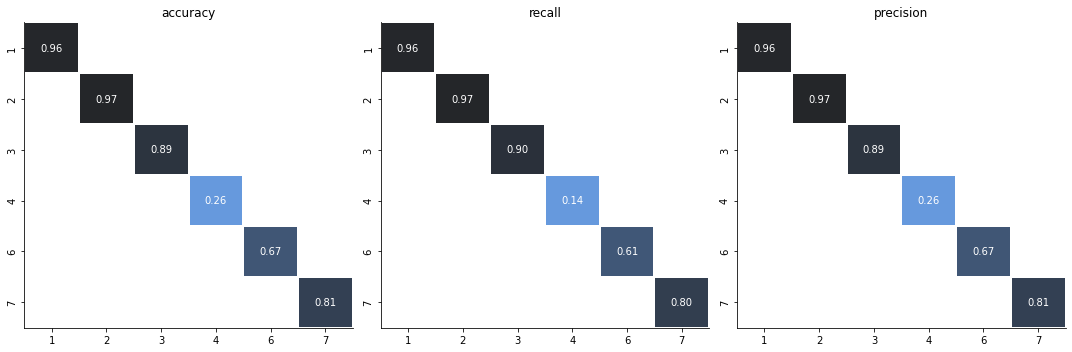

In [9]:
# prepare oof_predictions
oof_y_true = np.array(oof_preds['y_valid'])
oof_y_hat = le.inverse_transform(np.argmax(oof_preds['y_hat'], axis=1))

# create confusion matrix, calculate accuracy, recall & precision
cm = pd.DataFrame(data=confusion_matrix(oof_y_true, oof_y_hat, labels=le.classes_), index=le.classes_, columns=le.classes_)
plot_cm(cm)

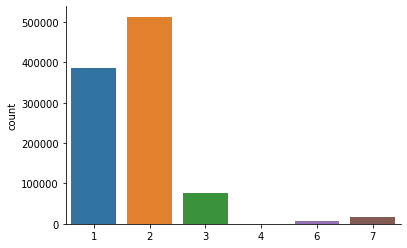

In [10]:
#create final prediction, inverse labels to original classes
final_predictions = le.inverse_transform(np.argmax(sum(predictions), axis=1))

sample_submission['Cover_Type'] = final_predictions
sample_submission.to_csv('./submission.csv', index=False)

sns.countplot(final_predictions)
sns.despine()

In [11]:
sample_submission.head()

,Id,Cover_Type
0,4000000,2
1,4000001,2
2,4000002,2
3,4000003,2
4,4000004,2
